## Importing all the *libraries*

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
import random
import matplotlib.pyplot as plt
import json
import os
import math
import warnings
warnings.filterwarnings('ignore' )

## Graph visualizations and saving the figure obtained

In [ ]:
c=['r','g']

for file in glob.glob("json_data/*.json"):
	f = open(file)
	data = json.load(f)
	y = data['rot_acc_y']
	x = data['rot_acc_x']
	z = data['rot_acc_z']


	plt.plot(range(0,len(z)), z)
	j = 0
	start = 0
	end = 0
	for i in data['anomalies']:
		start.append([data['rot_acc_x'][i['start']], data['rot_acc_y'][i['start']], data['rot_acc_z'][i['start']]])

		z1 = data['rot_acc_z'][i['start']:i['end']+1]
		coord = range(i['start'], i['end']+1)

		plt.scatter(coord,z1,color =c[j%2], marker ='o', s=100)
		j+=1


	plt.savefig('images/'+file.split('.')[0]+'.png')
	plt.close()

## Preparing the Training data 

In [ ]:
def read_json():
  df = pd.DataFrame()
  x =[]
  y = []
  z = []
  pot_hole =[]
  speed_ranges = []
  #runs through 30 json files
  for file in glob.glob("*.json"):
    f = open(file)
    data = json.load(f)
    y += data['rot_acc_y']
    x += data['rot_acc_x']
    z += data['rot_acc_z']
    pot_ranges =[]
    for i in data['anomalies']:
      #defining the range of the potholes
      pot_ranges+=[j for j in range(i['start'],i['end']+1)]
    for i in range(0,len(z)):
    #annotation of potholes
      if i in pot_ranges:
          pot_hole.append(1)
      else:
          pot_hole.append(0)
    for i in data['speed']:
      speed_ranges+=[i['speed'] for j in range(i['start'],i['end']+1)]
  df['pothole']=pot_hole
  df['speed'] = speed_ranges
  df['y'], df['x'], df['z'] = y, x, z
  # saving to a csv file
  df.to_csv('data/Training_data.csv')
  return

# Reading the prepared data

In [ ]:
df = pd.read_csv('data/Training_data.csv', index_col=0)

#Function to create windows of data

In [ ]:
def create_data(df, load_list, label=0):
  num = len(df)
  list_data = []
  i = 0
  while i+150 <= num:
    train_data=[]
    if label == 1:
      train_data = df[load_list].loc[i:i+150].to_numpy().flatten()
      if np.average(train_data)>=0.5:
        list_data.append(1)
      else:
        list_data.append(0)
    else:
      train_data = df[load_list].loc[i:i+150].to_numpy().flatten()
      list_data.append(train_data)
    i = i+1
  print('converting list to array')
  list_data = np.array(list_data)
  return list_data


def create_data2(df, load_list , vector_len = 150, label=0):
  num = len(df)
  if label==1:
    return [np.average(np.array(df[load_list].loc[i:i+vector_len-1].values)) for i in tqdm(range(num-vector_len+1))]
  return {i:np.array(df[load_list].loc[i:i+vector_len-1].values) for i in tqdm(range(num-vector_len+1))}

#Creating the windows of datapoints with its labels and saving 

In [ ]:
train_x = create_data2(df,['x','y','z','speed'], vector_len=200)
train_x = [train_x[i] for i in range(0,len(train_x))]
np.save('data/train_x_data.npy',np.array(train_x))
train_y = create_data2(df,['pothole'], vector_len=200, label =1)
a = np.array(train_y)
a[a>=0.5]=1
a[a<0.5] = 0
np.save('data/train_y_data.npy', a)

100%|██████████| 404692/404692 [12:30<00:00, 539.37it/s]


#Creating the model

In [ ]:
model = Sequential()

# Add 4 layers of LSTM
# First Layer
model.add(LSTM(units = 32, return_sequences = True, input_shape = (200, 4)))
model.add(Dropout(0.2))

# Second Layer
model.add(LSTM(units = 32, return_sequences = True))
model.add(Dropout(0.2))

# Third Layer
model.add(LSTM(units = 32, return_sequences = True))
model.add(Dropout(0.2))

# Fourth Layer
model.add(LSTM(units = 16, return_sequences = False))
model.add(Dropout(0.2))

# Dense layer
model.add(Dense(units = 16, activation ='sigmoid'))
model.add(Dropout(0.2))
# Dense layer
model.add(Dense(units = 1, activation ='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200, 32)           4736      
                                                                 
 dropout (Dropout)           (None, 200, 32)           0         
                                                                 
 lstm_1 (LSTM)               (None, 200, 32)           8320      
                                                                 
 dropout_1 (Dropout)         (None, 200, 32)           0         
                                                                 
 lstm_2 (LSTM)               (None, 200, 32)           8320      
                                                                 
 dropout_2 (Dropout)         (None, 200, 32)           0         
                                                                 
 lstm_3 (LSTM)               (None, 16)                3

#Compiling the model

In [ ]:
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['acc'])
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                patience=2, min_lr=0.0001)

#Loading the training data and labels

In [ ]:
train_x = np.load('data/train_x_eq_data.npy')
train_y = np.load('data/train_y_eq_data.npy')
Train_X, X_val, Train_Y, Y_val = train_test_split(train_x, train_y, test_size=0.3)

In [ ]:
print('Length of training data: ',len(Train_X))
print('Length of Validation data: ',len(X_val))

Length of training data:  71388
Length of Validation data:  30596


In [ ]:
len(train_x)

101984

#Training the model and saving it

In [ ]:
history = model.fit(Train_X,Train_Y,
                        epochs=25,
                        validation_data=(X_val, Y_val), callbacks = [reduce_lr],
                        verbose=1, batch_size = 512)

model.save('data/LSTM_model.h5')

Epoch 1/25
140/140 [==============================] - 19s 57ms/step - loss: 0.6320 - acc: 0.6272 - val_loss: 0.5796 - val_acc: 0.6748 - lr: 0.0010
Epoch 2/25
140/140 [==============================] - 7s 47ms/step - loss: 0.5697 - acc: 0.6813 - val_loss: 0.5581 - val_acc: 0.6790 - lr: 0.0010
Epoch 3/25
140/140 [==============================] - 7s 48ms/step - loss: 0.5406 - acc: 0.7227 - val_loss: 0.4827 - val_acc: 0.7769 - lr: 0.0010
Epoch 4/25
140/140 [==============================] - 7s 47ms/step - loss: 0.4983 - acc: 0.7601 - val_loss: 0.5307 - val_acc: 0.7191 - lr: 0.0010
Epoch 5/25
140/140 [==============================] - 7s 47ms/step - loss: 0.5078 - acc: 0.7519 - val_loss: 0.4608 - val_acc: 0.7945 - lr: 0.0010
Epoch 6/25
140/140 [==============================] - 7s 50ms/step - loss: 0.4667 - acc: 0.7868 - val_loss: 0.4302 - val_acc: 0.8062 - lr: 0.0010
Epoch 7/25
140/140 [==============================] - 6s 46ms/step - loss: 0.4262 - acc: 0.8098 - val_loss: 0.3904 - val_ac

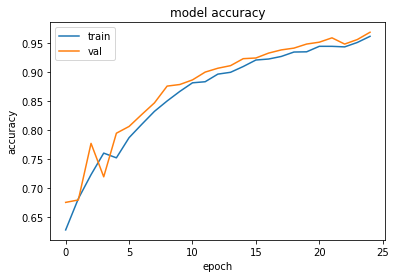

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

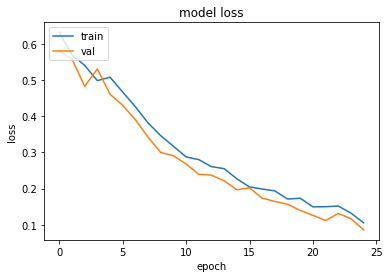

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Load the testing data

In [ ]:
df_test = pd.read_csv('data/Testing_data.csv', index_col=0)

#Convert the testing data into windowed data

In [ ]:
testing_x = create_data2(df_test,['x','y','z','speed'], vector_len=200)
testing_x = [testing_x[i] for i in range(0,len(testing_x))]
np.save('data/test_x_data.npy',np.array(testing_x))

testing_y = create_data2(df_test,['pothole'], vector_len=200, label =1)
a_t = np.array(testing_y)
a_t[a_t>=0.5]=1
a_t[a_t<0.5] = 0
np.save('data/test_y_data.npy', a_t)


100%|██████████| 694471/694471 [32:21<00:00, 357.62it/s]


#Load the testing data and model

In [ ]:
test_x = np.load('data/test_x_data.npy')
test_y = np.load('data/test_y_data.npy')
model = keras.models.load_model('data/LSTM_model.h5')

To generalize the data with pothole and without pothole has been made equal

In [ ]:
with_pot_x=[]
with_pot_y=[]
without_pot_x=[]
without_pot_y=[]
add_wop = False
for i in range(0,len(test_y)):
  if test_y[i] ==1:
    with_pot_x.append(test_x[i])
    with_pot_y.append(test_y[i])
  if test_y[i] == 0 and (len(without_pot_x)<91662):
    without_pot_x.append(test_x[i])
    without_pot_y.append(test_y[i])
    add_wop = False

with_pot_x= np.array(with_pot_x)
with_pot_y = np.array(with_pot_y)
without_pot_x = np.array(without_pot_x)
without_pot_y = np.array(without_pot_y)

In [ ]:
print('The test data labelled with pothole',len(with_pot_x))
print('The test data labelled without pothole',len(without_pot_x))

The test data labelled with pothole 91662
The test data labelled without pothole 91662


#Testing the model

In [ ]:
P_score = model.evaluate(with_pot_x,with_pot_y)
N_score = model.evaluate(without_pot_x, without_pot_y)
print('True Positive: '+ str(int(P_score[1]*len(with_pot_x))))
print('False Positive: '+ str(int((1-P_score[1])*len(with_pot_x))))
print('True Negative: '+ str(int(N_score[1]*len(without_pot_x))))
print('False Negative: '+ str(int((1-N_score[1])*len(without_pot_x))))

2865/2865 [==============================] - 35s 12ms/step - loss: 0.1174 - acc: 0.9562
True Positive: 82516
False Positive: 9145
True Negative: 87650
False Negative: 4011


In [ ]:
TP = int(P_score[1]*len(with_pot_x))
FN = int((1-P_score[1])*len(with_pot_x))
FP = int((1-N_score[1])*len(without_pot_x))
TN = int(N_score[1]*len(without_pot_x))
print('             Performance Metrics')
print('Precision: ', TP/(TP+FP))
print('Negative Predictive Value: ', TN/(TN+FN))
print('Accuracy: ', str(((TP+TN)/(TP+TN+FP+FN))*100)+'%')
print('Specificity: ', TN/(TN+FP))
print('Sensitivy: ', TP/(TP+FN))

             Performance Metrics
Precision:  0.953644527141817
Negative Predictive Value:  0.9055219794410868
Accuracy:  92.82355636530258%
Specificity:  0.9562409312575687
Sensitivy:  0.900230196048483


#Plotting Speed vs variance along z axis

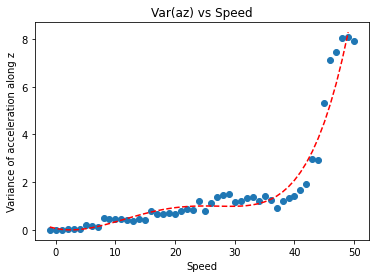

In [ ]:
from numpy import arange
from pandas import read_csv
from scipy.optimize import curve_fit
from matplotlib import pyplot

# define the true objective function
def objective(x, a, b, c, d, e, f):
	return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f



# curve fit
popt, _ = curve_fit(objective, x, y)
# summarize the parameter values
a, b, c, d, e, f= popt
# plot input vs output
pyplot.scatter(x, y)
# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 1)
# calculate the output for the range
y_line = objective(x_line, a, b, c, d, e, f)
print(str(a)+'x'+str(b+'x^2')
# create a line plot for the mapping function
pyplot.plot(x_line, y_line, '--', color='red')
pyplot.xlabel('Speed')
pyplot.ylabel('Variance of acceleration along z')
pyplot.title('Var(az) vs Speed')
pyplot.show()


#Function for reorientation of the axis 

In [ ]:
def transform(ax,ay,az):
  ax = ax/9.8
  ay = ay/9.8
  az = az/9.8
  if az>=1.00:
    return ax*9.8,ay*9.8,az*9.8
  else:
    theta =np.rad2deg(np.arccos(az))
    cos_theta = np.cos(np.deg2rad(theta))
    sin_theta = np.sin(np.deg2rad(theta))
    try:
      phi = np.rad2deg(np.arctan(ay/ax))
    except:
      phi = np.rad2deg(np.arctan(0))
    sin_phi = np.sin(np.deg2rad(phi))
    cos_phi = np.cos(np.deg2rad(phi))
    num = (ay*cos_phi)-(ax*sin_phi)
    den = (((ax*cos_phi)+(ay*sin_phi))*cos_theta) - (az * sin_theta)
    sih = np.rad2deg(np.arctan(num/den))
    sin_sih = np.sin(np.deg2rad(sih))
    cos_sih = np.cos(np.deg2rad(sih))
    atx = (ax*cos_phi*cos_theta*cos_sih) + (ay*sin_phi*cos_theta*cos_sih) - (az*sin_theta*cos_sih) + (ay*cos_phi*sin_sih) - (ax*sin_phi*sin_sih)
    aty = (ay*cos_phi*cos_sih)-(ax*sin_phi*cos_sih)-(ax*cos_phi*cos_theta*sin_sih)-(ay*sin_phi*cos_theta*sin_sih)+(az*sin_theta*sin_sih)
    atz = (ax*cos_phi*sin_theta)+(ay*sin_phi*sin_theta)+(az*cos_theta)

    return atx*9.8,aty*9.8,atz*9.8

In [ ]:
ax = 0.2776
ay = 8.1703
az = 4.346
speed = 110.23

In [ ]:
anx, any, anz = transform(ax,ay,az)

In [ ]:
model = keras.models.load_model('data/LSTM_model.h5')

#Reading the real world data collected

In [ ]:
test_dd =pd.read_excel('data/waterlootoGTA.xls')

#Deployed code

In [ ]:
data = []
gps_Lat = []
gps_Long = []
old_lat = 0
old_long = 0
print('------------------------Turning on pothole detector------------------------')
pot = 0
for i in tqdm(range(0,len(test_dd))):
  row = test_dd.iloc[i]
  d = []
  x = row['ACCELEROMETER X (m/s¬≤)']
  y = row['ACCELEROMETER Y (m/s¬≤)']
  z = row['ACCELEROMETER Z (m/s¬≤)']
  nx, ny, nz = transform(x,y,z)
  speed = row['LOCATION Speed ( Kmh)']
  Lat = row['LOCATION Latitude : ']
  Lon = row['LOCATION Longitude : ']
  data.append(np.array([nx,ny,nz,speed]))
  gps_Lat.append(Lat)
  gps_Long.append(Lon)
  d.append(np.array(data))
  if len(data)<200:  
    continue
  out = model.predict(np.array(d))
  dif = 0
  if out[0] >= 0.9:
    new_lat = np.average(np.array(gps_Lat))
    new_long = np.average(np.array(gps_Long))
    dif_lat = abs(new_lat - old_lat)
    dif_long = abs(new_lat - old_lat)
    if dif_lat>0.001 and dif_long >0.001:
      m = data
      pot+=1
      print('\n-----------------Pothole detected in the below location------------------')
      print('                   Latitude: ', np.average(np.array(gps_Lat)))
      print('                  Longitude: ', np.average(np.array(gps_Long)))
      print('                  Confidence: ', out[0])
    old_lat = np.average(np.array(gps_Lat))
    old_long = np.average(np.array(gps_Long))
  data.pop(0)
  gps_Lat.pop(0)
  gps_Long.pop(0)
print('\nDetected '+str(pot)+' potholes')
print('------------------------Turning off pothole detector------------------------')

------------------------Turning on pothole detector------------------------


  2%|▏         | 201/9393 [00:00<00:06, 1419.17it/s]


-----------------Pothole detected in the below location------------------
                   Latitude:  43.449944800000004
                  Longitude:  -80.17813339
                  Confidence:  [0.90115213]


 62%|██████▏   | 5827/9393 [04:31<02:51, 20.73it/s]


-----------------Pothole detected in the below location------------------
                   Latitude:  43.64042338499999
                  Longitude:  -79.38149322000001
                  Confidence:  [0.9926852]


 79%|███████▉  | 7424/9393 [05:47<01:32, 21.20it/s]


-----------------Pothole detected in the below location------------------
                   Latitude:  43.650318865
                  Longitude:  -79.37882162
                  Confidence:  [0.9608619]


 83%|████████▎ | 7757/9393 [06:03<01:16, 21.39it/s]


-----------------Pothole detected in the below location------------------
                   Latitude:  43.65574179
                  Longitude:  -79.37558203
                  Confidence:  [0.91613406]


100%|██████████| 9393/9393 [07:21<00:00, 21.30it/s]


Detected 4 potholes
------------------------Turning off pothole detector------------------------
